In [17]:

# Step 1: Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

import joblib


,Crop,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Crop                                  156 non-null    object 
 1   Precipitation (mm day-1)              156 non-null    float64
 2   Specific Humidity at 2 Meters (g/kg)  156 non-null    float64
 3   Relative Humidity at 2 Meters (%)     156 non-null    float64
 4   Temperature at 2 Meters (C)           156 non-null    float64
 5   Yield                                 156 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 7.4+ KB
Missing values:
 Crop                                    0
Precipitation (mm day-1)                0
Specific Humidity at 2 Meters (g/kg)    0
Relative Humidity at 2 Meters (%)       0
Temperature at 2 Meters (C)             0
Yield                                   0
dtype: int64


<Figure size 800x600 with 0 Axes>

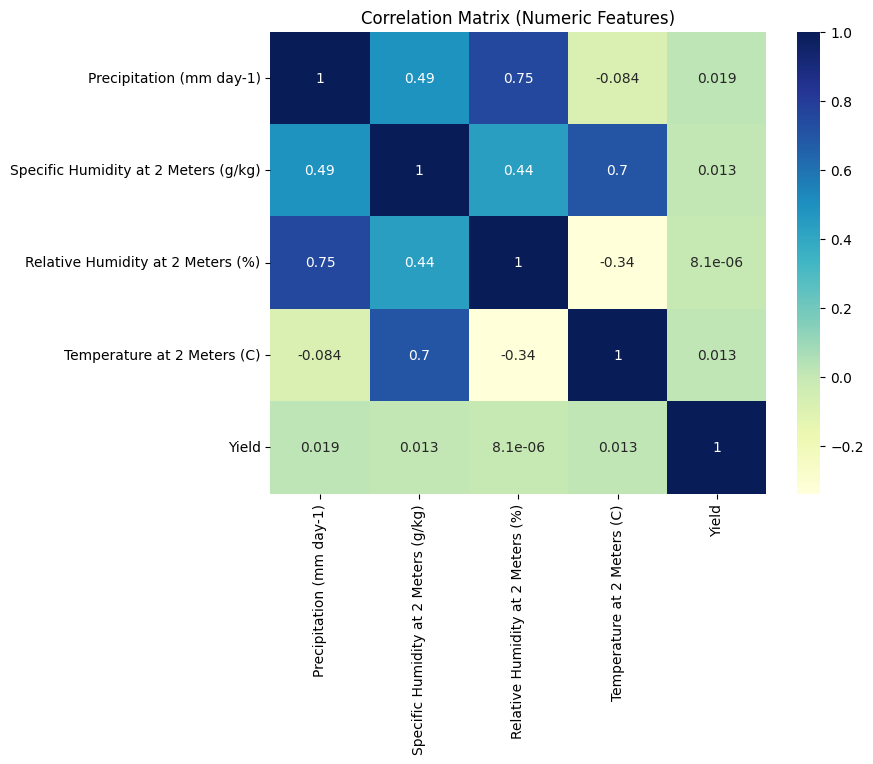

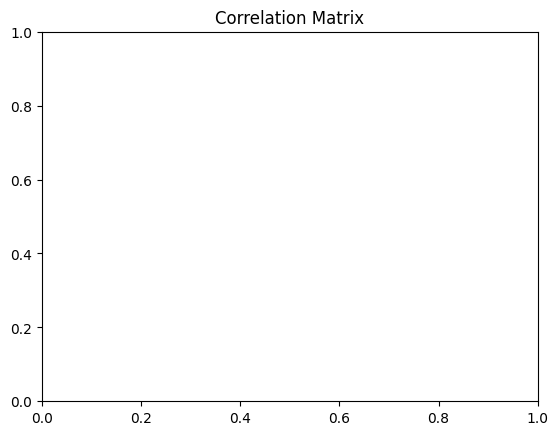

In [22]:


df = pd.read_csv("/kaggle/input/crop-yield-prediction3/crop yield prediction2.csv")

display(df.head())
df.info()
df.describe()

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Correlation matrix
plt.figure(figsize=(8,6))
# Select numeric columns only
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(8,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='YlGnBu')
plt.title('Correlation Matrix (Numeric Features)')
plt.show()

plt.title('Correlation Matrix')
plt.show()


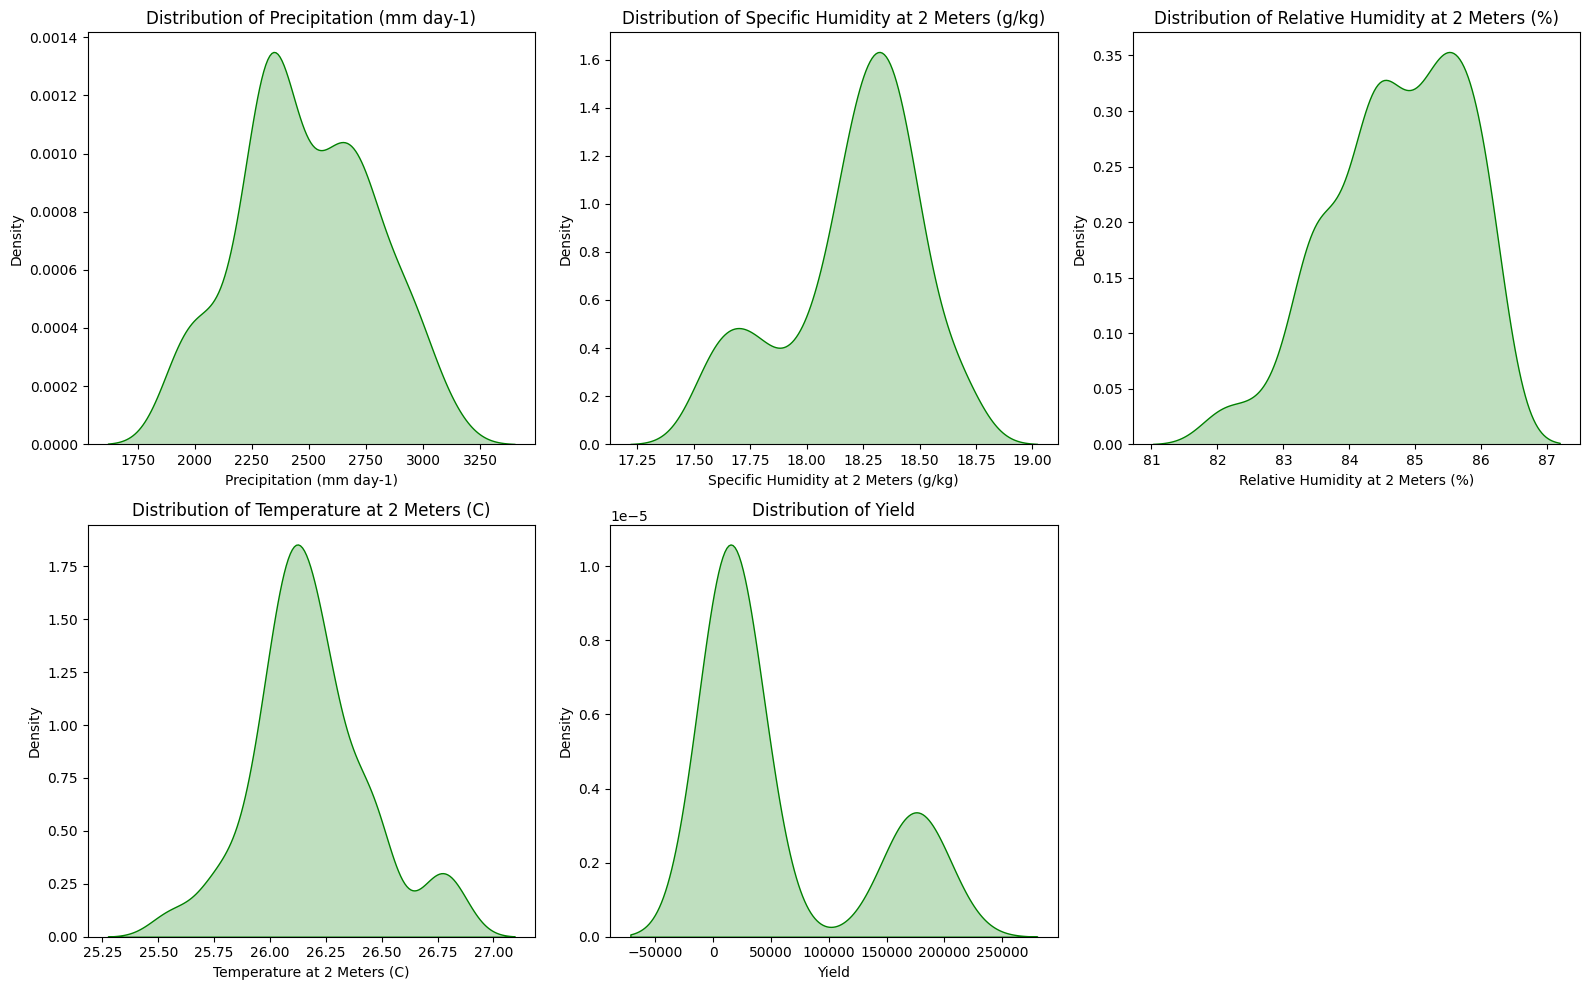

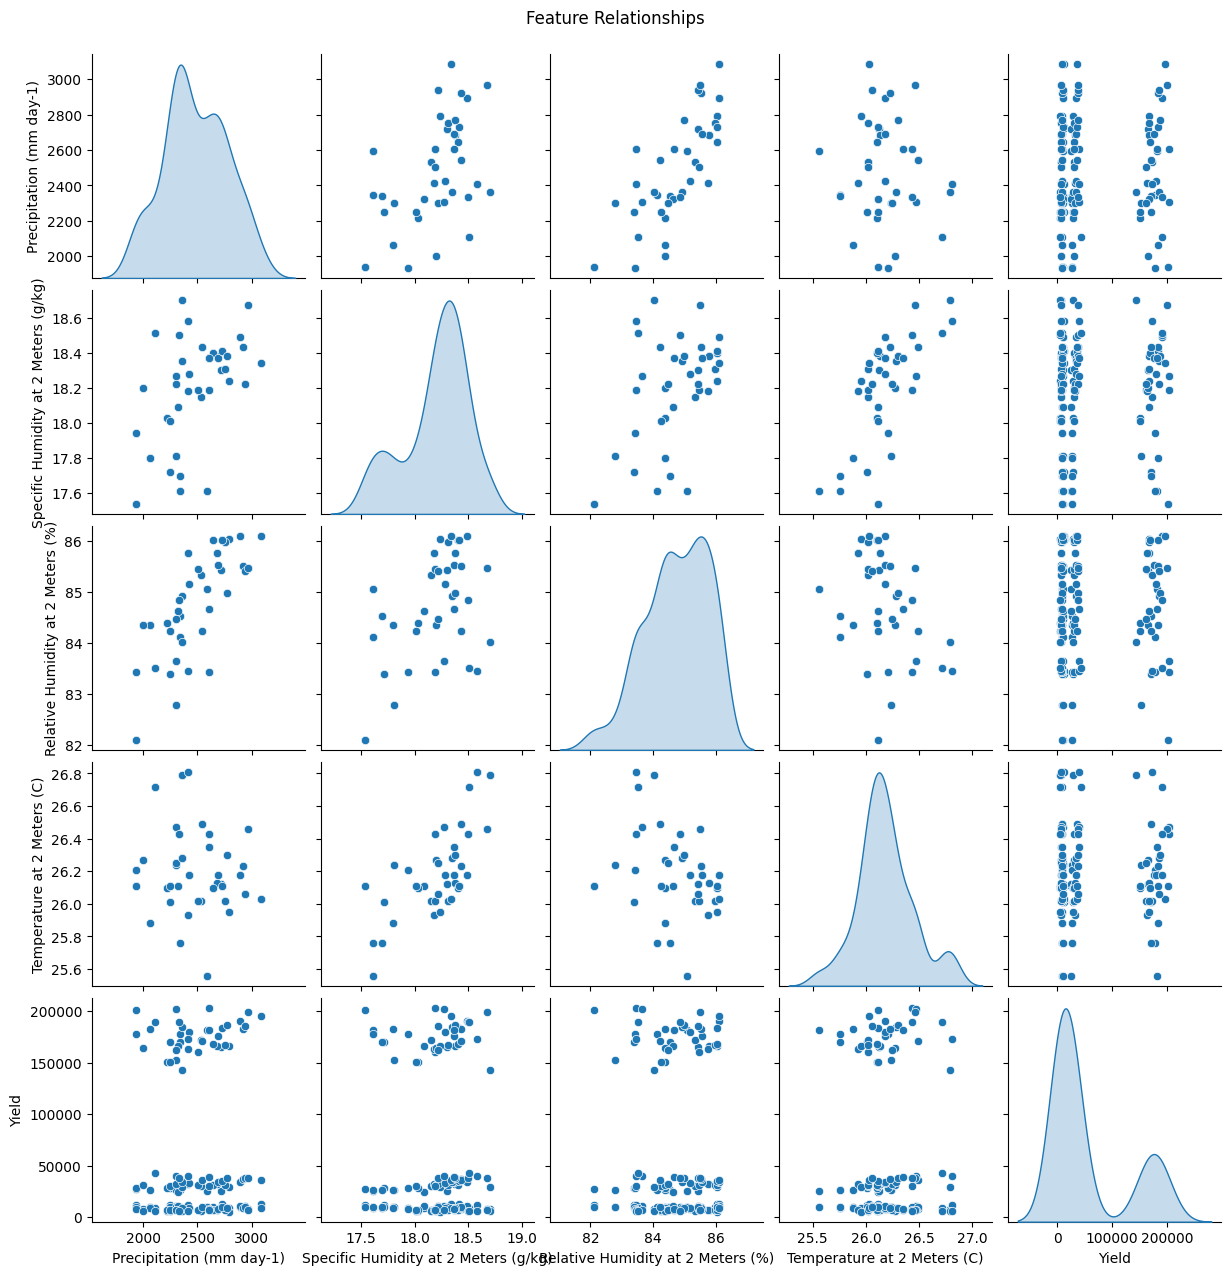

In [27]:

#  Step 3: Data Visualization (EDA)


# Distribution plots
# Correct column names from your dataset

# Features to plot (exclude 'Crop' categorical column)
features = ['Precipitation (mm day-1)', 'Specific Humidity at 2 Meters (g/kg)', 'Relative Humidity at 2 Meters (%)', 'Temperature at 2 Meters (C)', 'Yield']

# KDE plots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, feature in enumerate(features):
    sns.kdeplot(df[feature], shade=True, ax=axes[idx], color='green')
    axes[idx].set_title(f'Distribution of {feature}')

# Hide the empty 6th plot (since we have only 5 features)
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

numeric_df = df.select_dtypes(include=[np.number])   # Only numeric columns

sns.pairplot(numeric_df, diag_kind='kde')
plt.suptitle('Feature Relationships', y=1.02)
plt.show()



In [29]:

# Step 4: Data Preprocessing

# Features and target
X = df[['Precipitation (mm day-1)', 'Specific Humidity at 2 Meters (g/kg)', 'Relative Humidity at 2 Meters (%)', 'Temperature at 2 Meters (C)']]
y = df['Yield']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Feature scaling (important for KNN and Lasso)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


Training samples: 124, Testing samples: 32


In [32]:

# Step 5: Train Multiple Regression Models

models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost':xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42),
    'Lasso': Lasso(alpha=0.01),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'DecisionTree': DecisionTreeRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    if name in ['Lasso', 'KNN']:
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    
    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    print(f"✅ {name} — R2 Score: {r2:.2f}")


✅ RandomForest — R2 Score: -0.91
✅ XGBoost — R2 Score: -1.20
✅ Lasso — R2 Score: -0.06
✅ KNN — R2 Score: -0.47
✅ DecisionTree — R2 Score: -1.20


,MAE,RMSE,R2
Lasso,55211.340338,64100.321900,-0.059263
KNN,62039.312500,75559.090547,-0.471827
RandomForest,72215.165913,86057.887686,-0.909259
XGBoost,75914.263275,92331.963486,-1.197797
DecisionTree,75914.270833,92331.972828,-1.197797


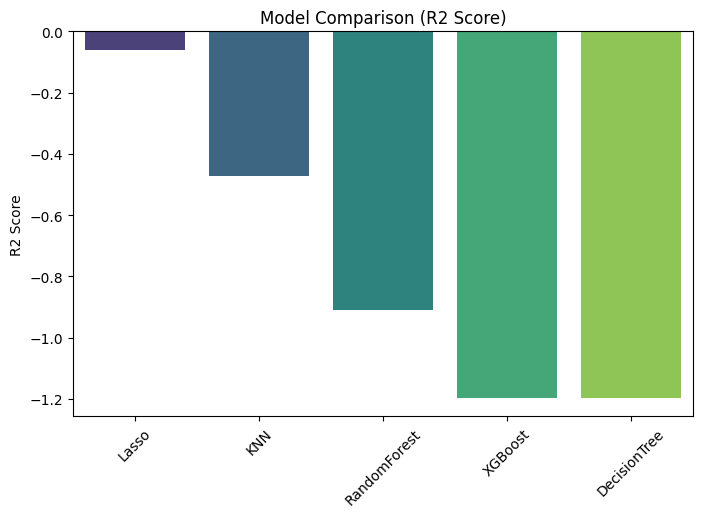

In [33]:
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('R2', ascending=False)
display(results_df)

plt.figure(figsize=(8,5))
sns.barplot(x=results_df.index, y=results_df['R2'], palette='viridis')
plt.title('Model Comparison (R2 Score)')
plt.ylabel('R2 Score')
plt.xticks(rotation=45)
plt.show()


In [34]:
# Assuming RandomForest performed best (you can check your table)
best_model = models['RandomForest']

joblib.dump(best_model, "crop_yield_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("🎉 Best Model & Scaler saved successfully!")


🎉 Best Model & Scaler saved successfully!


In [35]:
def predict_yield(input_data):
    model = joblib.load("crop_yield_model.pkl")
    scaler = joblib.load("scaler.pkl")
    
    # Since RandomForest was trained WITHOUT scaling
    prediction = model.predict([input_data])
    return prediction[0]

# Example usage
# Input = [Precipitation, Specific Humidity, Relative Humidity, Temperature]
sample_input = [120.0, 12.0, 75.0, 28.0]  # Example realistic values

predicted_yield = predict_yield(sample_input)
print(f"🌾 Predicted Crop Yield: {predicted_yield:.2f} quintals/hectare")


🌾 Predicted Crop Yield: 84502.46 quintals/hectare
